### Regressions incorporating same session and previous session regressions

1/ Across all sessions
2/ Separtately for each wave 
3/ From session to session 

In [6]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os
print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))

import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression as lm
from scipy.stats import zscore as zscore_sc
import bambi as bmb
import arviz as az
import bammm_local as mm
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import product, combinations

# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

trait_factor_names = ["TF1_CognAnxDepr", "TF2_PhysiolAnx", "TF3_NegativeAffect"]
trait_factor_names_short = ["TF1", "TF2",  "TF3",]



mapdict = {'TF3_NegativeAffect': 'TF3',
           'TF2_PhysiolAnx': 'TF2', 
           'TF1_CognAnxDepr': 'TF1',
           'stai_ta': "TA",
           'covid_worry': 'Worry', 
           'prob_est': 'Risk',
           'q7_worry_econ_impact': 'EconWorr',
           'q6_apply_soc_dist': 'SocialDist',
           'q6_risk_group': 'RiskGr',
           'avoid_beh': 'Avoidance',
           'avoid_anx': 'AvoidAnx',
           'q6_media_freq_num': 'InforSeek',
           'q6_media_valence': 'MediaVal',
           'q7_period_rel_danger': 'ThreatPerception',
           'deaths': 'Deaths',
           'cases': 'Cases',
           'worryhealth': 'HealthWorry',
           'q6_work_home': "WorkHome",
           'sticsa_som_sa_currsess': "StateSomAnx",
            "covid_thoughts": "CovThoughts", 
            "memory_worry_infected_baselined": "MemWorry", 
            "memory_prob_infected_baselined": "MemProb", 
           }

#vars = ["Avoidance", "InforSeek", "Risk", 
#        "ThreatPerception", "Deaths", "Cases"]

#vars = ["Avoidance", "InforSeek", "Risk", 
#        "ThreatPerception", "Worry", "AvoidAnx", "Deaths", "Cases"]


vars = ["Avoidance", "InforSeek", "Risk", 
        "ThreatPerception", "Cases"]

df=df.rename(columns=mapdict)
dfall = df.copy()

df = df.loc[:,vars+["PROLIFICID","session"]]#.set_index("PROLIFICID")
# Discretize the numeric vector
bins = [1, 7, 13, 21]
labels = ['spring_wave', 'summer', 'autumn_wave']
df["wave"] = pd.cut(df["session"], bins=bins, labels=labels, right=False, include_lowest=True)

# zscore each variable by session (for regressions)
for v in vars: 
    for s in df.session.unique(): 
      df.loc[df["session"]==s,v] = zscore_sc(np.array(df.loc[df["session"]==s,v]), nan_policy="omit")
    


def demultindex(df):
    df.columns = [ x+"_"+str(y) for x,y in df.columns ]
    return df

# Trait scores in a separate df
df_id = dfall.loc[:,["PROLIFICID"]+trait_factor_names_short].groupby(by="PROLIFICID").mean()

tdf = df.pivot(columns="session", index="PROLIFICID", values=vars)

/data/drive/postdoc/Project4_covid


### Build timelag dataset

In [7]:
win=1


for dvidx, dv in enumerate(vars):
    ## Prepare data set 
    regdf = pd.DataFrame()
    for s in np.arange(win+1,21):

        #tdf.loc[:,(dv,[1,2])]
        x_dv = demultindex(tdf.loc[:,(dv,np.arange(s-win,s+1))])
        x_dv = x_dv.rename(columns=dict(zip(x_dv.columns, [dv+"_lag"+str(x) for x in np.arange(win,-1, -1)])))

        x_dv["session"] = s
        x_dv["sess_str"] = "sess"+str(s)
        regdf = pd.concat([regdf, x_dv], axis=0)

    if dvidx == 0:
        fitdf = regdf
    else:
        fitdf = pd.merge(fitdf, regdf,  on=["PROLIFICID", "session"])

bins = [1, 7, 13, 21]
labels = ['spring_wave', 'summer', 'autumn_wave']
fitdf["wave"] = pd.cut(fitdf["session"], bins=bins, labels=labels, right=False, include_lowest=True)

### Diagnostics

When estimating t-1 and t at the same time, most variance is attributed to t. Is that justified or a consequence of inherent autocorrelation? 
Checking for variance inflation - I suspect that the model is unidentifiable due to multicollinearity.  

As an alternative, inspired by betwork analysis, we can estimate the t-1 first and then estimate t on residuals. 

#### VIFS for full model with t and t-1

spring_wave
summer
autumn_wave
mean      8.678958
median    6.462804
Name: VIF, dtype: float64


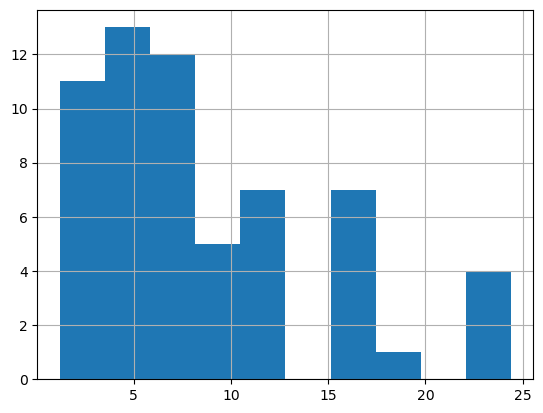

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
fitdf2=fitdf.dropna().join(df_id).reset_index()
inter_vars =list()
for tt in trait_factor_names_short:
    for v in vars:
        for lag in ["lag0", "lag1"]:
            fitdf2[v+"_"+lag+":"+tt] = fitdf2[v+"_"+lag] * fitdf2[tt]
            inter_vars.append(v+"_"+lag+":"+tt)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["var"] = [v+"_lag"+str(i) for v in vars for i in [0,1]] + ["session"] + ["TF1", "TF2", "TF3"] + inter_vars

# calculating VIF for each variable
vif_data["VIF"] = [vif(fitdf2.loc[:,vif_data["var"]], i) for i in range(len(vif_data["var"]))]

for w in ['spring_wave', 'summer', 'autumn_wave']: 
    print(w)
    fitdf3=fitdf2.loc[fitdf2["wave"]==w,].dropna()
    vif_data2 = pd.DataFrame()
    # calculating VIF for each variable
    
    vif_data["VIF_"+w] = [vif(fitdf3.loc[:,vif_data["var"]], i) for i in range(len(vif_data["var"]))]
    

vif_data["VIF"].hist()
vif_data.head(20)

print(vif_data["VIF"].agg(["mean", "median"]))

In [9]:
print(vif_data["VIF"].agg(["mean", "median"]))

mean      8.678958
median    6.462804
Name: VIF, dtype: float64


#### VIFs for step-wise model

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
fitdf2=fitdf.dropna().join(df_id).reset_index()
inter_vars =list()
for tt in trait_factor_names_short:
    for v in vars:
        for lag in ["lag1"]:
            fitdf2[v+"_"+lag+":"+tt] = fitdf2[v+"_"+lag] * fitdf2[tt]
            inter_vars.append(v+"_"+lag+":"+tt)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["var"] = [v+"_lag"+str(i) for v in vars for i in [1]] + ["session"] + ["TF1", "TF2", "TF3"]  + inter_vars

# calculating VIF for each variable
vif_data["VIF"] = [vif(fitdf2.loc[:,vif_data["var"]], i) for i in range(len(vif_data["var"]))]

for w in ['spring_wave', 'summer', 'autumn_wave']: 
    print(w)
    fitdf3=fitdf2.loc[fitdf2["wave"]==w,].dropna()
    vif_data2 = pd.DataFrame()
    # calculating VIF for each variable
    
    vif_data["VIF_"+w] = [vif(fitdf3.loc[:,vif_data["var"]], i) for i in range(len(vif_data["var"]))]
    

vif_data

spring_wave
summer
autumn_wave


var       VIF  VIF_spring_wave  VIF_summer  \
0              Avoidance_lag1  1.460542         1.448053    1.532179   
1              InforSeek_lag1  1.112034         1.090377    1.161686   
2                   Risk_lag1  1.503079         1.542606    1.511479   
3       ThreatPerception_lag1  1.401332         1.465817    1.349542   
4                  Worry_lag1  2.170242         2.430078    2.232189   
5                 Deaths_lag1  1.382428         1.556161    1.576786   
6                  Cases_lag1  1.372153         1.477807    1.505468   
7                     session  1.180499         1.226278    1.303666   
8                         TF1  3.625883         3.621219    3.808727   
9                         TF2  1.842862         1.912086    1.936531   
10                        TF3  2.893079         2.872574    3.128931   
11         Avoidance_lag1:TF1  5.463639         5.229663    5.639587   
12         InforSeek_lag1:TF1  3.981205         4.018289    4.059649   
13              Risk_lag1:TF1  5.469687         5.839126    5.421817   
14  ThreatPerception_lag1:TF1  5.983686         5.991103    5.846705   
15             Worry_lag1:TF1  7.849051         7.817334    7.920107   
16            Deaths_lag1:TF1  5.212907         4.686505    7.343491   
17             Cases_lag1:TF1  4.776174         4.393650    6.240016   
18         Avoidance_lag1:TF2  2.706881         2.643984    2.601395   
19         InforSeek_lag1:TF2  1.622008         1.515435    1.679541   
20              Risk_lag1:TF2  3.767905         3.348996    4.001042   
21  ThreatPerception_lag1:TF2  2.773145         2.651078    2.647189   
22             Worry_lag1:TF2  4.977420         4.605870    4.990131   
23            Deaths_lag1:TF2  2.467985         2.136635    3.689638   
24             Cases_lag1:TF2  2.397308         2.166452    3.614762   
25         Avoidance_lag1:TF3  3.875661         3.695692    4.263543   
26         InforSeek_lag1:TF3  3.188691         3.398520    3.243535   
27              Risk_lag1:TF3  3.902459         4.035211    4.004712   
28  ThreatPerception_lag1:TF3  4.044692         4.081917    4.133182   
29             Worry_lag1:TF3  5.535039         5.736688    5.714212   
30            Deaths_lag1:TF3  3.611602         3.453599    4.669478   
31             Cases_lag1:TF3  3.246333         3.094597    3.527492   

    VIF_autumn_wave  
0          1.550640  
1          1.154714  
2          1.549659  
3          1.525347  
4          2.165948  
5          1.428853  
6          1.342895  
7          1.227183  
8          3.661660  
9          1.845515  
10         2.924571  
11         5.996808  
12         4.146820  
13         5.676199  
14         6.680490  
15         8.343505  
16         4.849823  
17         4.566329  
18         3.080516  
19         1.800695  
20         4.348629  
21         3.210336  
22         5.655932  
23         2.272623  
24         2.190918  
25         4.155190  
26         3.239174  
27         4.123689  
28         4.383528  
29         5.827702  
30         3.632406  
31         3.334839

In [11]:
vif_data["VIF"].hist()

<AxesSubplot:>

In [12]:
print(vif_data["VIF"].agg(["mean", "median"]))

mean      3.337425
median    3.217512
Name: VIF, dtype: float64


### Single model across all sessions

In [13]:
def determine_lag_status(text):
    if 'lag0' in text:
        return 'lag0'
    elif 'lag1' in text:
        return 'lag1'
    else:
        return 'na'

ddf = pd.DataFrame()
fitdf2=fitdf.dropna().join(df_id).reset_index()
for dvidx, dv in enumerate(vars):
    dvs = [v+"*"+tf for v in list(fitdf.columns[fitdf.columns.str.contains("_lag1")])+list(fitdf.columns[fitdf.columns.str.contains("_lag0")]) for tf in ["TF1", "TF2", "TF3"] ]
    dvs = [i for i in dvs if dv+"_lag0" not in i]

    eq = mm.generate_equation(dv+"_lag0",  ["session"]+dvs, [""], "reducedrank") 
    md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
    res = md.fit(method=['bfgs'])


    edf = res.conf_int(alpha=0.05)
    edf.columns = ["CI5", "CI95"]
    edf["beta"] = res.params
    edf["dv"] = dv 
    edf["p"] = round(res.pvalues, 4)
    #edf["session"] = s
    if dvidx == 0:
        fitdf = regdf
    #edf["wave"] = w
    edf["eff_raw"] = edf.index
    edf["eff_type"] = edf["eff_raw"].apply(lambda x: 'interaction' if ':' in x else 'maineff')
    edf["eff_time"] = edf["eff_raw"].apply(determine_lag_status)
    edf["indiff"] = edf.index.str.split(":").str[1]
    edf["iv"] = edf.index.str.split("_").str[0]

    ddf = pd.concat([ddf, edf.reset_index()])
var_to_id = {var: i for i, var in enumerate(vars)}

# Create dv_id and iv_id columns
ddf['dv_id'] = ddf['dv'].map(var_to_id)
ddf['iv_id'] = ddf['iv'].map(var_to_id)

In [14]:
ddf.loc[(ddf["eff_type"] == "maineff") & ((ddf["eff_time"] == "lag1") | (ddf["eff_time"] == "na")) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["dv"] != "Cases"), :]

index       CI5      CI95      beta                dv  \
0               Intercept -0.050817  0.062187  0.005685         Avoidance   
1                 session -0.003054  0.001677 -0.000688         Avoidance   
3                     TF1 -0.150485  0.022028 -0.064229         Avoidance   
5                     TF2 -0.092488  0.037530 -0.027479         Avoidance   
7                     TF3  0.051258  0.203706  0.127482         Avoidance   
9          InforSeek_lag1 -0.019930  0.028421  0.004245         Avoidance   
13              Risk_lag1 -0.030313  0.038563  0.004125         Avoidance   
17  ThreatPerception_lag1 -0.026963  0.014117 -0.006423         Avoidance   
21             Worry_lag1 -0.003552  0.061913  0.029180         Avoidance   
25            Deaths_lag1 -0.011031  0.029173  0.009071         Avoidance   
29             Cases_lag1 -0.044317 -0.001285 -0.022801         Avoidance   
57              Group Var  0.611694  0.947053  0.779374         Avoidance   
0               Intercept -0.108494  0.097134 -0.005680         InforSeek   
1                 session -0.003882  0.001655 -0.001113         InforSeek   
2              Cases_lag1 -0.020113  0.024671  0.002279         InforSeek   
3                     TF1 -0.048440  0.299364  0.125462         InforSeek   
5                     TF2 -0.144862  0.111520 -0.016671         InforSeek   
7                     TF3 -0.276562  0.027088 -0.124737         InforSeek   
13              Group Var  1.939551  2.747281  2.343416         InforSeek   
0               Intercept -0.102253  0.108085  0.002916              Risk   
1                 session -0.001757  0.002316  0.000280              Risk   
2              Cases_lag1 -0.015356  0.017588  0.001116              Risk   
3                     TF1 -0.118260  0.245180  0.063460              Risk   
5                     TF2  0.029750  0.297665  0.163708              Risk   
7                     TF3 -0.083192  0.234116  0.075462              Risk   
13              Group Var  3.975046  5.604774  4.789910              Risk   
0               Intercept -0.101437  0.077788 -0.011825  ThreatPerception   
1                 session -0.003147  0.003707  0.000280  ThreatPerception   
2              Cases_lag1 -0.021451  0.033996  0.006273  ThreatPerception   
3                     TF1 -0.034578  0.254292  0.109857  ThreatPerception   
5                     TF2 -0.000956  0.211971  0.105508  ThreatPerception   
7                     TF3 -0.112554  0.139634  0.013540  ThreatPerception   
13              Group Var  0.840494  1.203040  1.021767  ThreatPerception   
0               Intercept -0.105670  0.087419 -0.009125             Worry   
1                 session -0.002211  0.002047 -0.000082             Worry   
2              Cases_lag1 -0.014680  0.019761  0.002540             Worry   
3                     TF1 -0.063776  0.267637  0.101931             Worry   
5                     TF2  0.033686  0.277990  0.155838             Worry   
7                     TF3  0.085160  0.374505  0.229833             Worry   
13              Group Var  3.010200  4.249527  3.629863             Worry   

         p                eff_raw eff_type eff_time indiff                iv  \
0   0.8437              Intercept  maineff       na    NaN         Intercept   
1   0.5685                session  maineff       na    NaN           session   
3   0.1444                    TF1  maineff       na    NaN               TF1   
5   0.4074                    TF2  maineff       na    NaN               TF2   
7   0.0010                    TF3  maineff       na    NaN               TF3   
9   0.7307         InforSeek_lag1  maineff     lag1    NaN         InforSeek   
13  0.8144              Risk_lag1  maineff     lag1    NaN              Risk   
17  0.5400  ThreatPerception_lag1  maineff     lag1    NaN  ThreatPerception   
21  0.0806             Worry_lag1  maineff     lag1    NaN             Worry   
25  0.3765            Deaths_lag1  maineff     lag1    NaN    



### Plot same-session relationships

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

for lag, lbl in zip(["lag0", "lag1"], ["contemporaneous", "temporal (t-1)"]):

    tddf = ddf.loc[(ddf["eff_type"] == "maineff") & ((ddf["eff_time"] ==lag) | (ddf["eff_time"] == "na")) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

    # Normalize beta values for the colormap, centered on 0 with symmetrical limits
    max_abs_beta = 0.2
    #max_abs_beta = max(abs(ddf['beta'].min()), abs(ddf['beta'].max()))
    norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

    # Create a custom colormap
    cmap = plt.get_cmap('PiYG')

    vars_with_tfs = vars + trait_factor_names_short

    # Grid settings
    n_vars = len(vars_with_tfs)
    circle_radius = 0.25
    arrow_scale = 0.5
    within_wave_dist = 4

    # Adjust figure size for a continuous plot
    fig, ax = plt.subplots(figsize=(8, 9))

    # Draw circles for previous and subsequent columns
    for i in range(n_vars):
        ax.add_patch(plt.Circle((0, i), circle_radius, color='gray', fill=False))
        ax.add_patch(plt.Circle((within_wave_dist, i), circle_radius, color='gray', fill=False))

    # Draw arrows within the continuous sequence
    for index, row in tddf.iterrows():
        dv_id = row['dv_id']
        iv_id = row['iv_id']
        beta = row['beta']
        color = cmap(norm(beta))
        ax.arrow(0, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

    # Add variable labels on the left
    for i, var in enumerate(vars_with_tfs):
        ax.text(-1.5, i, var, verticalalignment='center', horizontalalignment='right')

    # Setting the limits and aspect ratio
    ax.set_xlim(-1.5, within_wave_dist + 1)  # Adjusted the limit to reduce whitespace
    ax.set_ylim(-0.5, n_vars + 0.5)
    ax.set_aspect('equal')

    ax.set_title(lbl+" network")

    # Hide the axes
    ax.axis('off')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Add colorbar with adjusted size and position
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.01, aspect=15)  # Reduced size and spacing of colorbar
    cbar.set_label('Beta Value')

    plt.show()



### Plot same session modulations by trait factors

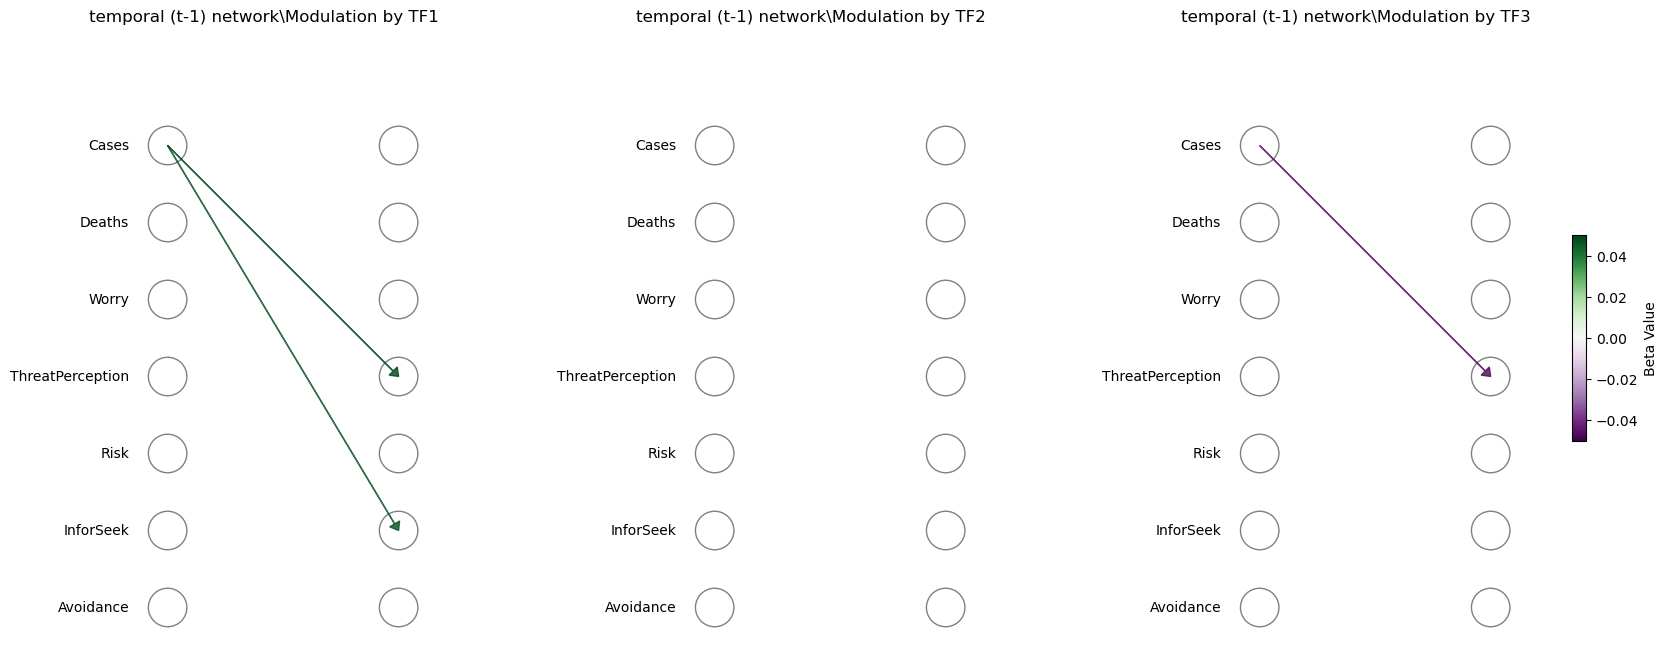

In [16]:
for lag, lbl in zip(["lag0", "lag1"], ["contemporaneous", "temporal (t-1)"]):
    fig, ax = plt.subplots(1,3,figsize=(20, 8))
    for id_idx, id in enumerate(trait_factor_names_short):
        tddf = ddf.loc[(ddf["eff_type"] == "interaction") & ((ddf["eff_time"] ==lag) | (ddf["eff_time"] == "na")) & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]
        #tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["eff_time"]=="lag0") & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") , :]

        # Normalize beta values for the colormap, centered on 0 with symmetrical limits
        max_abs_beta = 0.05
        norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

        # Create a custom colormap
        cmap = plt.get_cmap('PRGn')

        vars_with_tfs = vars 

        # Grid settings
        n_vars = len(vars_with_tfs)
        circle_radius = 0.25
        arrow_scale = 0.5
        within_wave_dist = 3

        

        # Draw circles for previous and subsequent columns
        for i in range(n_vars):
            ax[id_idx].add_patch(plt.Circle((0, i), circle_radius, color='gray', fill=False))
            ax[id_idx].add_patch(plt.Circle((within_wave_dist, i), circle_radius, color='gray', fill=False))

        # Draw arrows within the continuous sequence
        for index, row in tddf.iterrows():
            dv_id = row['dv_id']
            iv_id = row['iv_id']
            beta = row['beta']
            color = cmap(norm(beta))
            ax[id_idx].arrow(0, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

        # Add variable labels on the left
        for i, var in enumerate(vars_with_tfs):
            ax[id_idx].text(-0.5, i, var, verticalalignment='center', horizontalalignment='right')
        
        # Add title
        ax[id_idx].set_title(lbl+" network\Modulation by "+id)

        # Setting the limits and aspect ratio
        ax[id_idx].set_xlim(-1.5, within_wave_dist + 1)  # Adjusted the limit to reduce whitespace
        ax[id_idx].set_ylim(-0.5, n_vars + 0.5)
        ax[id_idx].set_aspect('equal')

        # Hide the axes
        ax[id_idx].axis('off')

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

    # Add colorbar with adjusted size and position
    cbar = plt.colorbar(sm, ax=ax[2], orientation='vertical', fraction=0.03, pad=0.01, aspect=15)  # Reduced size and spacing of colorbar
    cbar.set_label('Beta Value')

plt.show()


### Split by waves 

In [17]:
ddf = pd.DataFrame()
for w in ['spring_wave', 'summer', 'autumn_wave']:
    fitdf2=fitdf.loc[fitdf["wave"]==w,:].dropna().join(df_id).reset_index()
    for dvidx, dv in enumerate(vars):
        print(w+"_"+dv)
        dvs = [v+"*"+tf for v in list(fitdf.columns[fitdf.columns.str.contains("_lag1")])+list(fitdf.columns[fitdf.columns.str.contains("_lag0")]) for tf in ["TF1", "TF2", "TF3"] ]
        dvs = [i for i in dvs if dv+"_lag0" not in i]
        eq = mm.generate_equation(dv+"_lag0",  ["session"]+dvs, [""], "reducedrank") 
        md = smf.mixedlm(eq, fitdf2, groups=fitdf2["PROLIFICID"]) 
        res = md.fit(method=['bfgs'])

        edf = res.conf_int(alpha=0.05)
        edf.columns = ["CI5", "CI95"]
        edf["beta"] = res.params
        edf["dv"] = dv 
        edf["p"] = round(res.pvalues, 4)
        edf["wave"] = w
        edf["eff_raw"] = edf.index
        edf["eff_type"] = edf["eff_raw"].apply(lambda x: 'interaction' if ':' in x else 'maineff')
        edf["eff_time"] = edf["eff_raw"].apply(determine_lag_status)
        edf["indiff"] = edf.index.str.split(":").str[1]
        edf["iv"] = edf.index.str.split("_").str[0]

        ddf = pd.concat([ddf, edf.reset_index()])

KeyError: 'wave'

In [ ]:
# Map variables to IDs
var_to_id = {var: i for i, var in enumerate(vars)}

# Create dv_id and iv_id columns
ddf['dv_id'] = ddf['dv'].map(var_to_id)
ddf['iv_id'] = ddf['iv'].map(var_to_id)



In [ ]:
for lag, lbl in zip(["lag0", "lag1"], ["contemporaneous", "temporal (t-1)"]):
    tddf = ddf.loc[(ddf["eff_type"] == "maineff") & (ddf["eff_time"]==lag) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

    # Normalize beta values for the colormap, centered on 0 with symmetrical limits
    # max_abs_beta = max(abs(ddf['beta'].min()), abs(ddf['beta'].max()))
    max_abs_beta = 0.1
    norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

    # Create a custom colormap
    cmap = plt.get_cmap('PRGn')

    vars_with_tfs = vars + trait_factor_names_short

    # Grid settings
    waves = ['spring_wave', 'summer', 'autumn_wave']
    n_waves = len(waves)
    n_vars = len(vars_with_tfs)
    circle_radius = 0.25
    arrow_scale = 0.5
    within_wave_dist = 3

    # Adjust figure size for wider plot
    fig, ax = plt.subplots(figsize=(n_waves * 12, 6))

    # Draw circles for previous and subsequent columns
    for w, wave in enumerate(waves):
        base_x = w * 6  # Increased gap between waves
        for i in range(n_vars):
            ax.add_patch(plt.Circle((base_x, i), circle_radius, color='gray', fill=False))
            ax.add_patch(plt.Circle((base_x + within_wave_dist, i), circle_radius, color='gray', fill=False))  # Doubled the distance

    # Draw arrows within each wave
    for index, row in tddf.iterrows():
        wave_from = row['wave']
        w = waves.index(wave_from)
        base_x = w * 6
        dv_id = row['dv_id']
        iv_id = row['iv_id']
        beta = row['beta']
        color = cmap(norm(beta))
        ax.arrow(base_x, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

    # Add variable labels on the left
    for i, var in enumerate(vars_with_tfs):
        ax.text(-1.5, i, var, verticalalignment='center', horizontalalignment='right')  # Reduced the whitespace by half

    # Add wave names and column labels
    for w, wave in enumerate(waves):
        base_x = w * 6
        ax.text(base_x, n_vars, wave + "\nprevious", horizontalalignment='center', verticalalignment='bottom')
        ax.text(base_x + within_wave_dist, n_vars, "subsequent", horizontalalignment='center', verticalalignment='bottom')  # Adjusted the position

    # Setting the limits and aspect ratio
    ax.set_xlim(-1.5, n_waves * 6 + 2)  # Adjusted the limit to reduce whitespace
    ax.set_ylim(-0.5, n_vars + 0.5)
    ax.set_aspect('equal')
    ax.set_title(lbl+ " network")

    # Hide the axes
    ax.axis('off')

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Add colorbar with adjusted size and position
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.02, aspect=30)  # Reduced size and spacing of colorbar
    cbar.set_label('Beta Value')

    plt.show()

### plot modulation by TFs by wave 

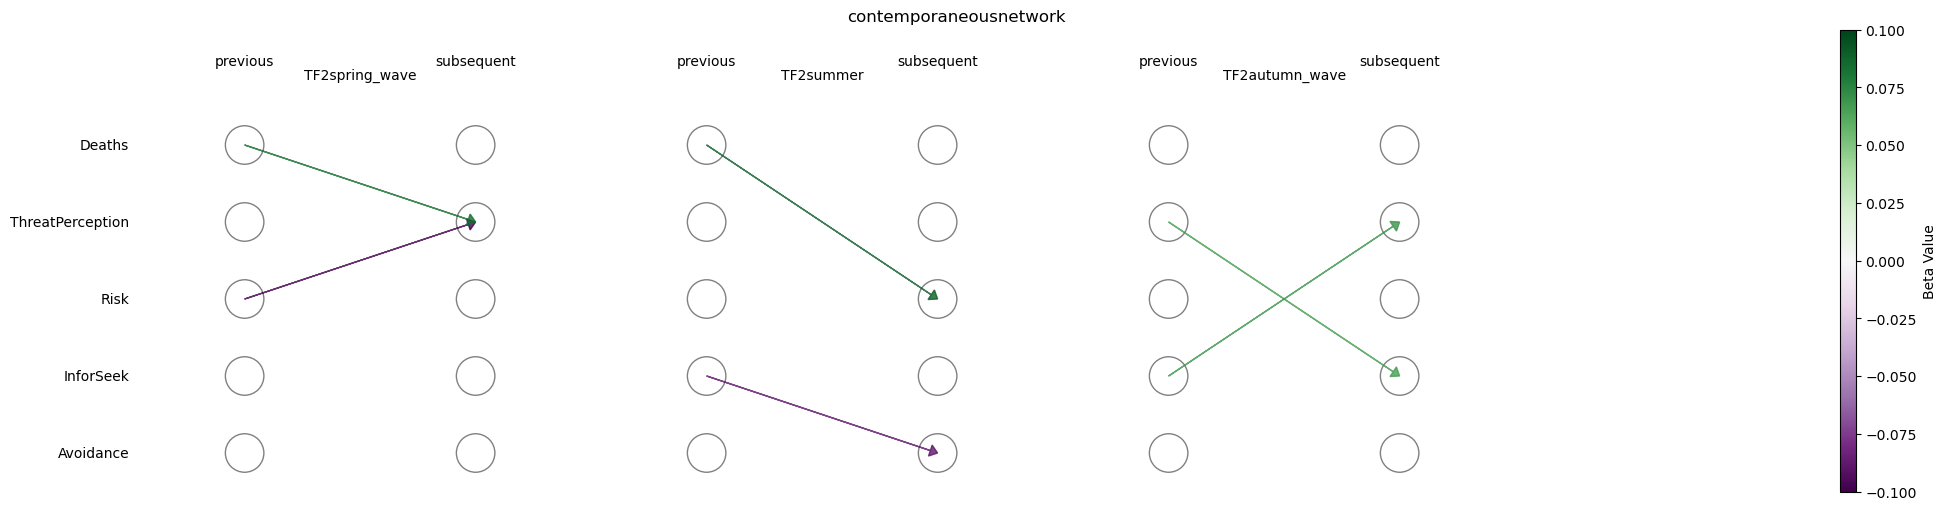

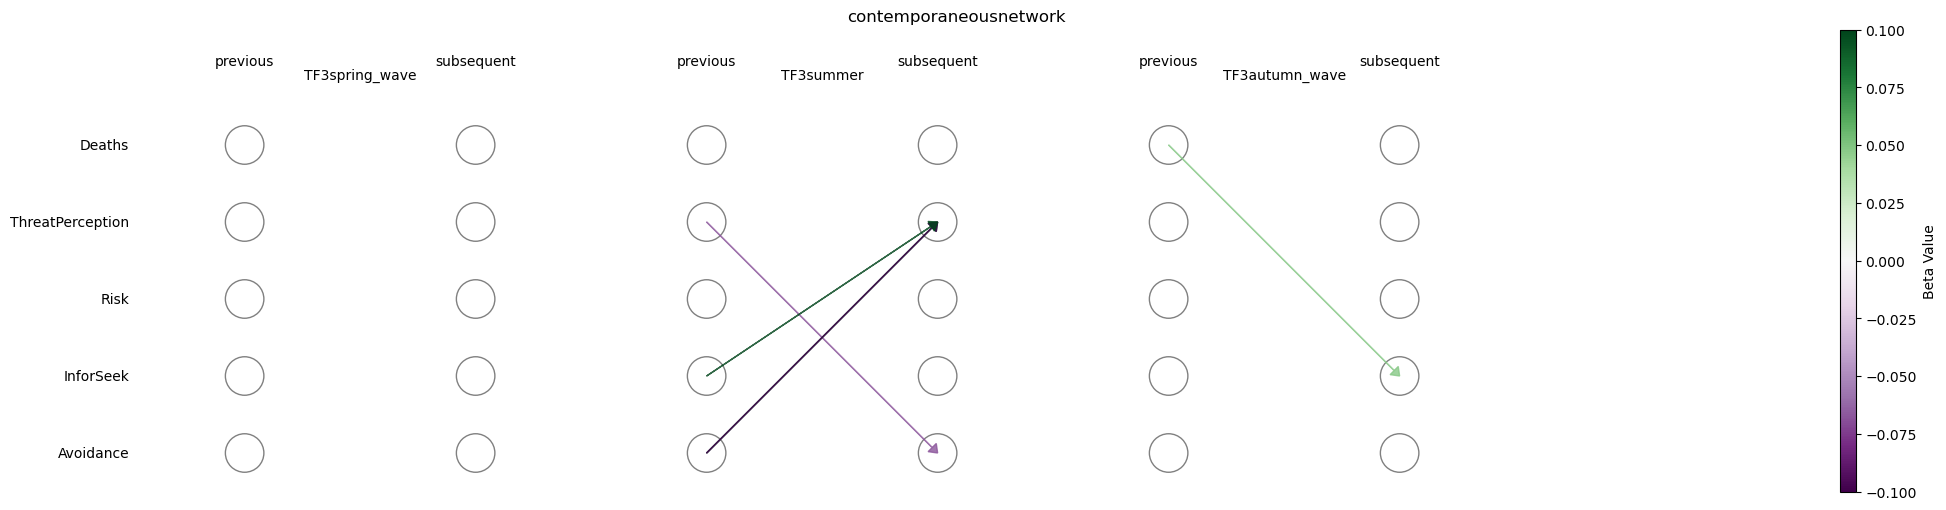

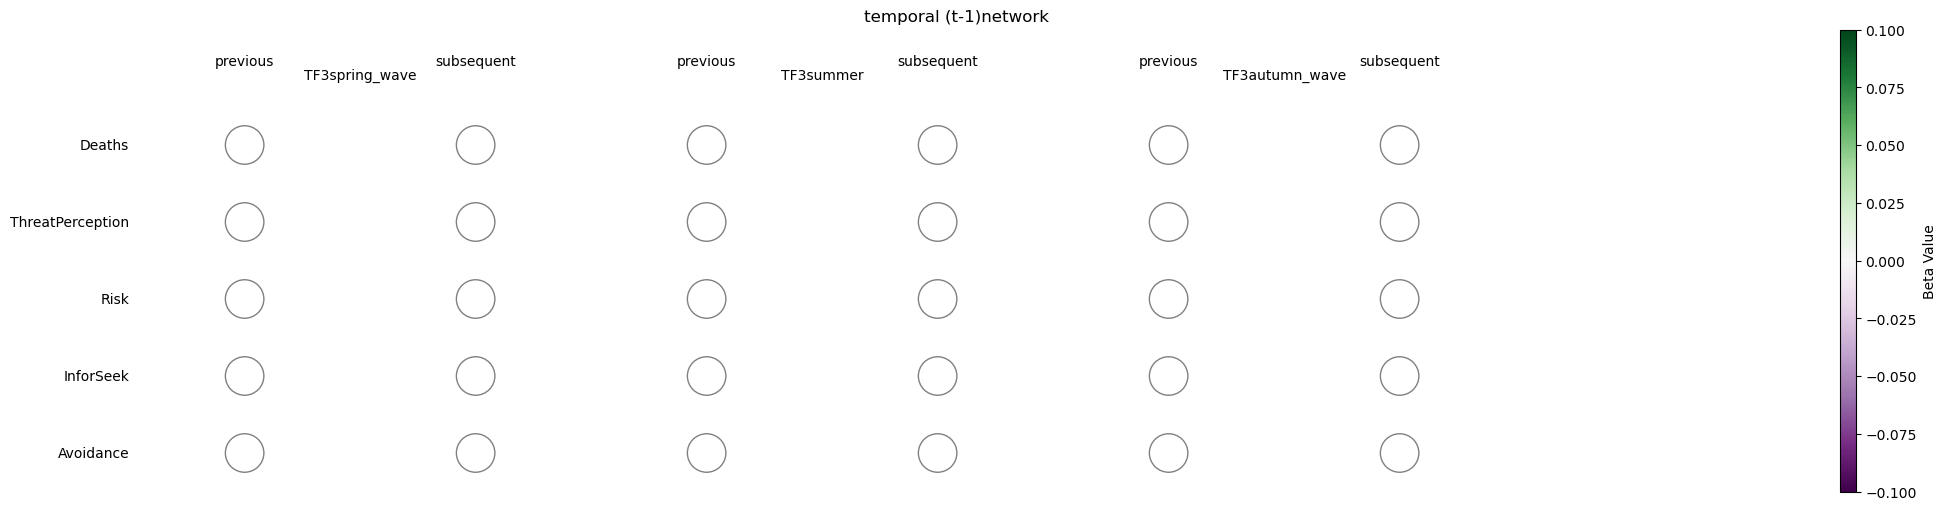

In [ ]:
for lag, lbl in zip(["lag0", "lag1"], ["contemporaneous", "temporal (t-1)"]):
    for id in trait_factor_names_short:
        tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["eff_time"]==lag) & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]
        #tddf = ddf.loc[(ddf["eff_type"] == "interaction") & (ddf["indiff"] == id) & (ddf['iv'] != ddf["dv"]) & (ddf["dv"] != "Deaths") & (ddf["dv"] != "Cases") & (ddf["p"]<0.05), :]

        # Normalize beta values for the colormap, centered on 0 with symmetrical limits
        # max_abs_beta = max(abs(ddf['beta'].min()), abs(ddf['beta'].max()))
        max_abs_beta = 0.1
        norm = mcolors.TwoSlopeNorm(vmin=-max_abs_beta, vcenter=0, vmax=max_abs_beta)

        # Create a custom colormap
        cmap = plt.get_cmap('PRGn')

        vars_with_tfs = vars 

        # Grid settings
        waves = ['spring_wave', 'summer', 'autumn_wave']
        n_waves = len(waves)
        n_vars = len(vars_with_tfs)
        circle_radius = 0.25
        arrow_scale = 0.5
        within_wave_dist = 3

        # Adjust figure size for wider plot
        fig, ax = plt.subplots(figsize=(n_waves * 12, 6))

        # Draw circles for previous and subsequent columns
        for w, wave in enumerate(waves):
            base_x = w * 6  # Increased gap between waves
            for i in range(n_vars):
                ax.add_patch(plt.Circle((base_x, i), circle_radius, color='gray', fill=False))
                ax.add_patch(plt.Circle((base_x + within_wave_dist, i), circle_radius, color='gray', fill=False))  # Doubled the distance

        # Draw arrows within each wave
        for index, row in tddf.iterrows():
            wave_from = row['wave']
            w = waves.index(wave_from)
            base_x = w * 6
            dv_id = row['dv_id']
            iv_id = row['iv_id']
            beta = row['beta']
            color = cmap(norm(beta))
            ax.arrow(base_x, iv_id, within_wave_dist, dv_id - iv_id, head_width=0.15, head_length=0.1, fc=color, ec=color, length_includes_head=True, alpha=0.8)  # Adjusted the arrow length

        # Add variable labels on the left
        for i, var in enumerate(vars_with_tfs):
            ax.text(-1.5, i, var, verticalalignment='center', horizontalalignment='right')  # Reduced the whitespace by half
        


        # Add wave names and column labels
        for w, wave in enumerate(waves):
            base_x = w * 6
            ax.text(base_x+within_wave_dist/2, n_vars, id+wave , horizontalalignment='center', verticalalignment='top')
            ax.text(base_x, n_vars, "previous", horizontalalignment='center', verticalalignment='bottom')
            ax.text(base_x + within_wave_dist, n_vars, "subsequent", horizontalalignment='center', verticalalignment='bottom')  # Adjusted the position

        # Setting the limits and aspect ratio
        ax.set_xlim(-1.5, n_waves * 6 + 2)  # Adjusted the limit to reduce whitespace
        ax.set_ylim(-0.5, n_vars + 0.5)
        ax.set_aspect('equal')
        ax.set_title(lbl+ "network")

        # Hide the axes
        ax.axis('off')

        # Add colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        # Add colorbar with adjusted size and position
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.02, aspect=30)  # Reduced size and spacing of colorbar
        cbar.set_label('Beta Value')

        plt.show()